# Airbnb First Booking Prediction

## Problem Statement

Ever wonder why you have certain promotion while your friends don't receive it? This business strategy is called personalized marketing. The goal of personalized marketing is to attract prospective customers and retain loyal customers.

This project will attempt to classify whether or not new users will book the room services within a month after they create their airbnb accounts. After the classification, we can send personalized promotions to those who have created their accounts but have not made any booking yet within a month.

Based on ShareBetter, the daily rate on average for an Airbnb rental was $160.47 in 2016. Airbnb charge travelers a 6-12% service fee, depending on the total of the reservation and 3% from the host for every booking that is completed.

## Features
train_users.csv<br>
**id**: user id<br>
**date_account_created**: the date of account creation<br>
**timestamp_first_active**: timestamp of the first activity, note that it can be earlier than date_account_created or  date_first_booking because a user can search before signing up<br>
**date_first_booking**: date of first booking<br>
**gender**<br>
**age**<br>
**signup_method**<br>
**signup_flow**: the page a user came to signup up from<br>
**language**: international language preference<br>
**affiliate_channel**: what kind of paid marketing<br>
**affiliate_provider**: where the marketing is e.g. google, craigslist, other<br>
**first_affiliate_tracked**: whats the first marketing the user interacted with before the signing up<br>
**signup_app**<br>
**first_device_type**<br>
**first_browser**<br>
**country_destination**: this is the target variable you are to predict<br>
sessions.csv - web sessions log for users<br>
**user_id**: to be joined with the column 'id' in users table<br>
**action**<br>
**action_type**<br>
**action_detail**<br>
**device_type**<br>
**secs_elapsed**<br>

countries.csv - summary statistics of destination countries in this dataset and their locations<br>
**age_gender_bkts.csv** - summary statistics of users' age group, gender, country of destination<br>

## Target

In this project, we are trying to predict whether a potential customer will book his or her first room within a month after they browses the Airbnb website for the first time. Since we don't have a column for our predictive target yet, we will create a column with two classes Y/N using the difference between timestamps of the first activity and date_first_booking.

In [374]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [375]:
train=pd.read_csv('airbnb-recruiting-new-user-bookings/train_users_2.csv', low_memory = False)

In [173]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [174]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [376]:
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
train['date_first_booking'] = pd.to_datetime(train['date_first_booking'])
train['timestamp_first_active'] = pd.to_datetime((train.timestamp_first_active // 1000000), format='%Y%m%d')

In [377]:
#calculate the time between they first browse the website and they first booked a room
train['delta']=train['date_first_booking']-train['timestamp_first_active']
train['delta']=train['delta'].astype('timedelta64[D]')

In [378]:
#some of the users have not booked any room yet, so we set them to 0
train['delta']=train.delta.fillna(0)

In [379]:
#set 1 if the difference between the date the first browsed on airbnb and the date they booked 
#their rooms is less than 30
train['book_within_a_month'] = [1 if x<30 else 0 for x in train['delta']]

In [380]:
train.drop('delta',axis=1,inplace=True)

In [180]:
#some people didn't use their real age when they signed up
train[train['age']>80].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2771 entries, 388 to 213345
Data columns (total 17 columns):
id                         2771 non-null object
date_account_created       2771 non-null datetime64[ns]
timestamp_first_active     2771 non-null datetime64[ns]
date_first_booking         1451 non-null datetime64[ns]
gender                     2771 non-null object
age                        2771 non-null float64
signup_method              2771 non-null object
signup_flow                2771 non-null int64
language                   2771 non-null object
affiliate_channel          2771 non-null object
affiliate_provider         2771 non-null object
first_affiliate_tracked    2710 non-null object
signup_app                 2771 non-null object
first_device_type          2771 non-null object
first_browser              2771 non-null object
country_destination        2771 non-null object
book_within_a_month        2771 non-null int64
dtypes: datetime64[ns](3), float64(1), int64(2), o

In [182]:
train[train['age']<18].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 193 to 211276
Data columns (total 17 columns):
id                         158 non-null object
date_account_created       158 non-null datetime64[ns]
timestamp_first_active     158 non-null datetime64[ns]
date_first_booking         22 non-null datetime64[ns]
gender                     158 non-null object
age                        158 non-null float64
signup_method              158 non-null object
signup_flow                158 non-null int64
language                   158 non-null object
affiliate_channel          158 non-null object
affiliate_provider         158 non-null object
first_affiliate_tracked    136 non-null object
signup_app                 158 non-null object
first_device_type          158 non-null object
first_browser              158 non-null object
country_destination        158 non-null object
book_within_a_month        158 non-null int64
dtypes: datetime64[ns](3), float64(1), int64(2), object(11)
memory us

In [381]:
#since it's only 1% of the data has outliner age, we can drop them
train.drop(train[train['age']>80].index, axis=0, inplace=True)

In [382]:
#since it's only 1% of the data has outliner age, we can drop them
train.drop(train[train['age']<18].index, axis=0, inplace=True)

In [184]:
train.country_destination.value_counts()

NDF      123087
US        61355
other      9909
FR         4956
IT         2776
GB         2280
ES         2216
CA         1405
DE         1043
NL          749
AU          531
PT          215
Name: country_destination, dtype: int64

In [312]:
def draw_plot(column,title,rotation,palette):
    plt.figure(figsize=(12,6))
    sns.set_style("darkgrid")
    sns.countplot(data=train,x=column,hue = 'book_within_a_month', order=train[column].value_counts().index,palette=('Blues_d'))
    sns.set_context("poster")
    plt.ylabel('Number of users')
    plt.xlabel('')
    plt.title(title)
    plt.xticks(rotation=rotation)
    sns.despine()
    plt.legend(loc=1, ncol=2)
    

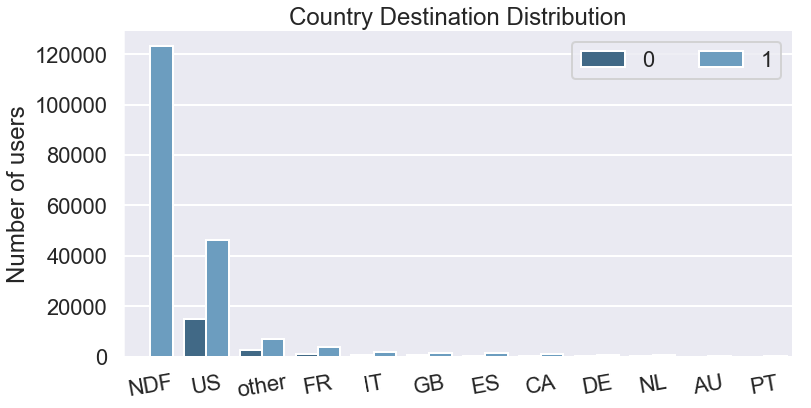

In [186]:

draw_plot('country_destination','Country Destination Distribution',10,'Blues_d')


In [383]:
#we want to drop country_destination because one level in country_destination is NDF
#which means no destination found. This level is highly correlated to book_within_a_month
train.drop(['id','country_destination'],axis=1,inplace=True)

In [384]:
#We create this column to see which day of the week and month do people tend to make their first room reservation
#In this case, we will know when will be the best time to send them promotion code
train['day_of_week_first_booking'] = train['date_first_booking'].dt.day_name()
train['month_first_booking'] = train['date_first_booking'].dt.month_name()

In [189]:
train.head()

,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,book_within_a_month,day_of_week_first_booking,month_first_booking
0,2010-06-28,2009-03-19,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,1,NaN,NaN
1,2011-05-25,2009-05-23,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,1,NaN,NaN
2,2010-09-28,2009-06-09,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,0,Monday,August
3,2011-12-05,2009-10-31,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,0,Saturday,September
4,2010-09-14,2009-12-08,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,0,Thursday,February


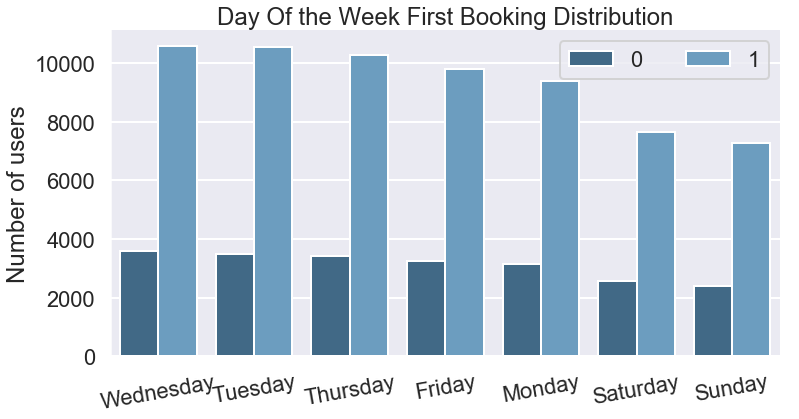

In [190]:

draw_plot('day_of_week_first_booking','Day Of the Week First Booking Distribution',10,'Blues_d')


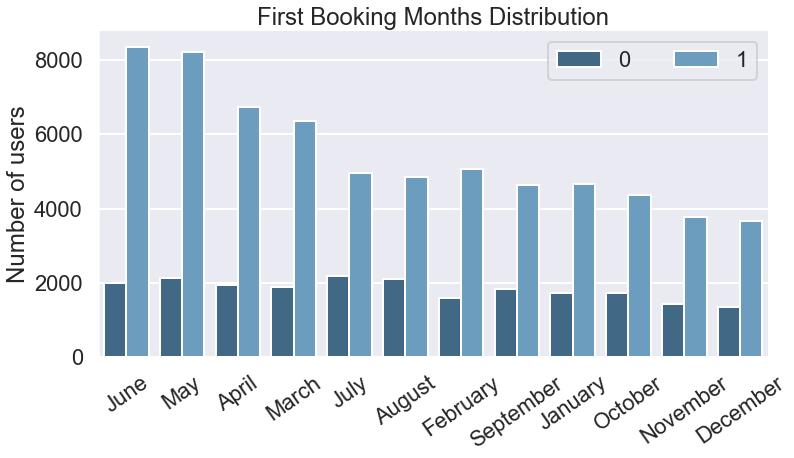

In [191]:
draw_plot('month_first_booking','First Booking Months Distribution',35,'Blues_d')

In [192]:
train.isnull().sum()
#57% of the data missing their first date of booking

date_account_created              0
timestamp_first_active            0
date_first_booking           123087
gender                            0
age                           87990
signup_method                     0
signup_flow                       0
language                          0
affiliate_channel                 0
affiliate_provider                0
first_affiliate_tracked        5982
signup_app                        0
first_device_type                 0
first_browser                     0
book_within_a_month               0
day_of_week_first_booking    123087
month_first_booking          123087
dtype: int64

In [237]:
#first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
train['first_affiliate_tracked'].value_counts()#the majory classes are untracked

untracked        107842
linked            45597
omg               43365
tracked-other      6038
product            1526
marketing           139
local ops            33
Name: first_affiliate_tracked, dtype: int64

In [385]:
#after we get the difference, we don't need the timestamp anymore
train.drop(['date_account_created','timestamp_first_active','date_first_booking'], axis=1, inplace=True)

In [195]:
# signup_flow: the page a user came to signup up from
train.signup_flow.describe()

count    210522.000000
mean          3.287428
std           7.659966
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          25.000000
Name: signup_flow, dtype: float64

In [196]:
train.columns

Index(['gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'book_within_a_month', 'day_of_week_first_booking',
       'month_first_booking'],
      dtype='object')

In [386]:
#There were “unknown” in gender column and first_browser column, we will fill “unknown” with “Other”.
train.gender.replace('-unknown-', 'OTHER', inplace=True)
train.first_browser.replace('-unknown-','Other', inplace=True)

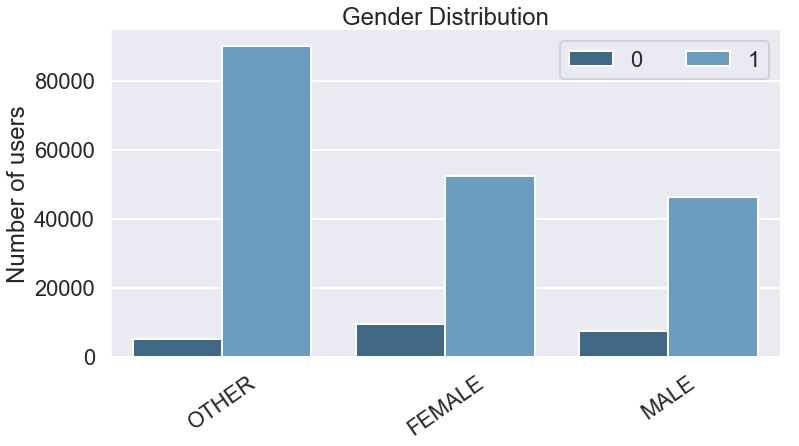

In [198]:
draw_plot('gender','Gender Distribution',35,'Blues_d')

In [199]:
train.signup_method.value_counts()

basic       150880
facebook     59097
google         545
Name: signup_method, dtype: int64

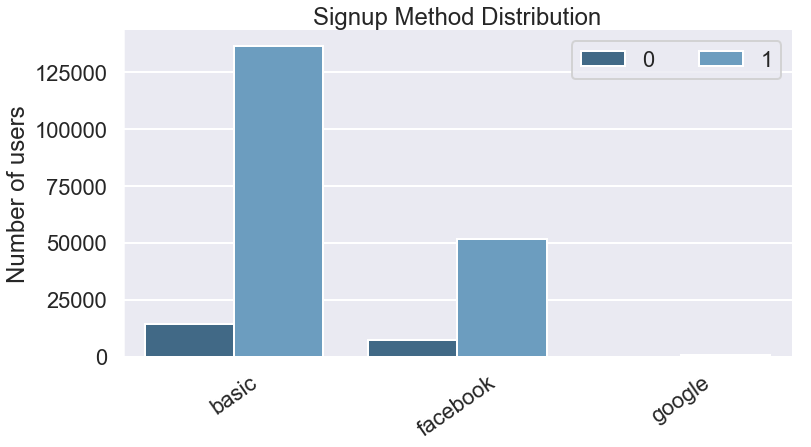

In [200]:
draw_plot('signup_method','Signup Method Distribution',35,'Blues_d')

In [387]:
#first_affiliate_tracked
train.first_affiliate_tracked.replace(np.nan,'untracked', inplace=True)

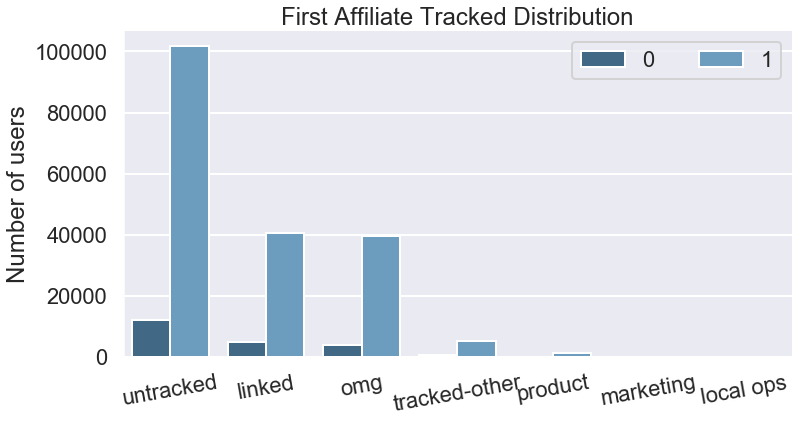

In [202]:
draw_plot('first_affiliate_tracked','First Affiliate Tracked Distribution',10,'Blues_d')

In [388]:
#language: since most people speak EN, we can group the other languages as others
for i in train.language.unique():
    if i != 'en':
        train.language.replace(i,'Other',inplace=True)

In [288]:
train.language.unique()

array(['en', 'Other'], dtype=object)

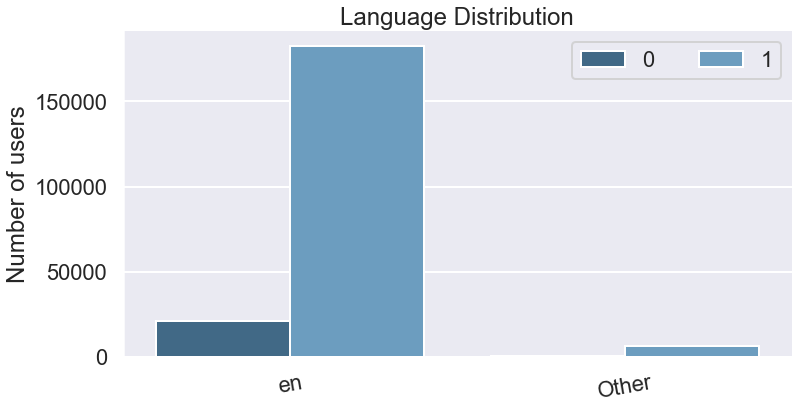

In [268]:
draw_plot('language','Language Distribution',10,'Blues_d')

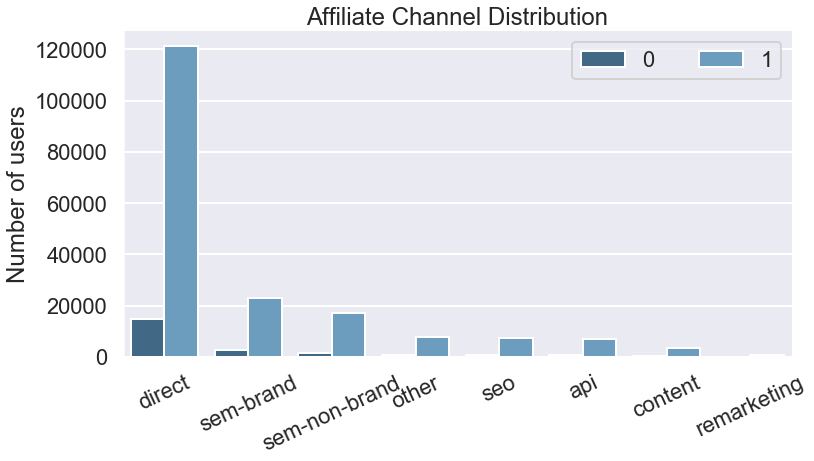

In [206]:
draw_plot('affiliate_channel','Affiliate Channel Distribution',25,'Blues_d')

In [269]:
train.affiliate_provider.unique()

array(['direct', 'google', 'other', 'craigslist', 'facebook', 'vast',
       'bing', 'meetup', 'facebook-open-graph', 'email-marketing',
       'yahoo', 'padmapper', 'gsp', 'wayn', 'naver', 'baidu', 'yandex',
       'daum'], dtype=object)

In [389]:
col=['vast','padmapper','facebook-open-graph','yahoo','gsp','meetup','email-marketing',
     'naver', 'baidu', 'yandex','daum','wayn','other']

In [390]:
for i in train.affiliate_provider.unique():
    if i in col:
        train.affiliate_provider.replace(i,'Other',inplace=True)

In [391]:
train.affiliate_provider.value_counts()

direct        135626
google         50888
Other          16057
craigslist      3406
bing            2294
facebook        2251
Name: affiliate_provider, dtype: int64

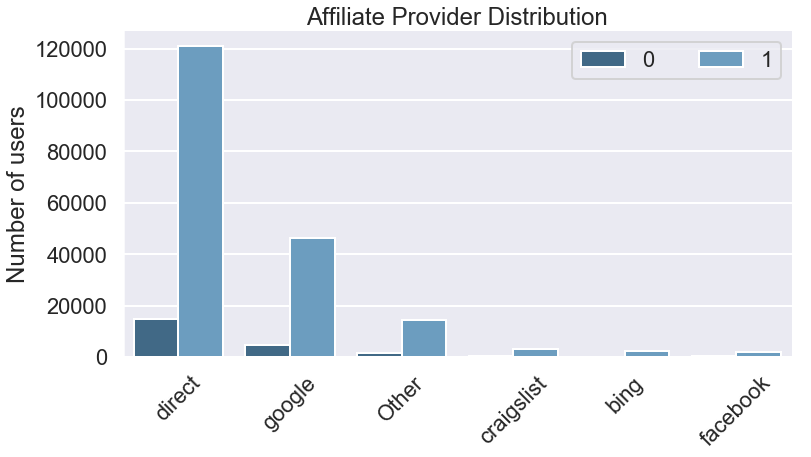

In [296]:
plt.figure(figsize=(12,6))
sns.set_style("darkgrid")
sns.countplot(data=train,x='affiliate_provider',hue = 'book_within_a_month', order=train['affiliate_provider'].value_counts().index,palette=('Blues_d'))
sns.set_context("poster")
plt.ylabel('Number of users')
plt.xlabel('')
plt.title('Affiliate Provider Distribution')
plt.xticks(rotation=45)
sns.despine()
plt.legend(loc=1, ncol=2);


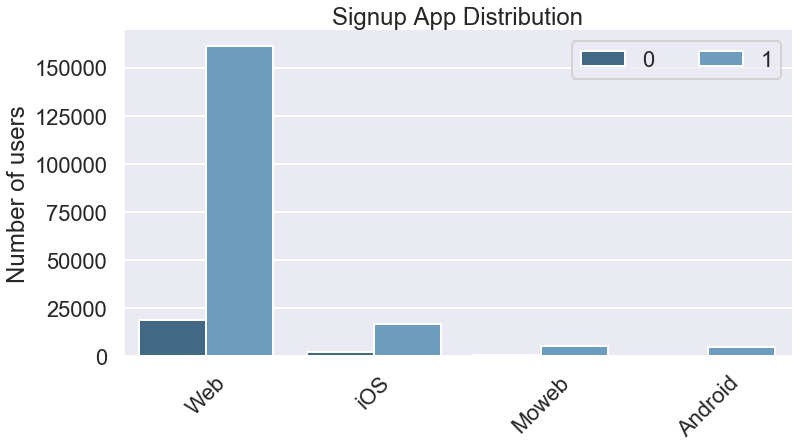

In [212]:
draw_plot('signup_app','Signup App Distribution',45,'Blues_d')

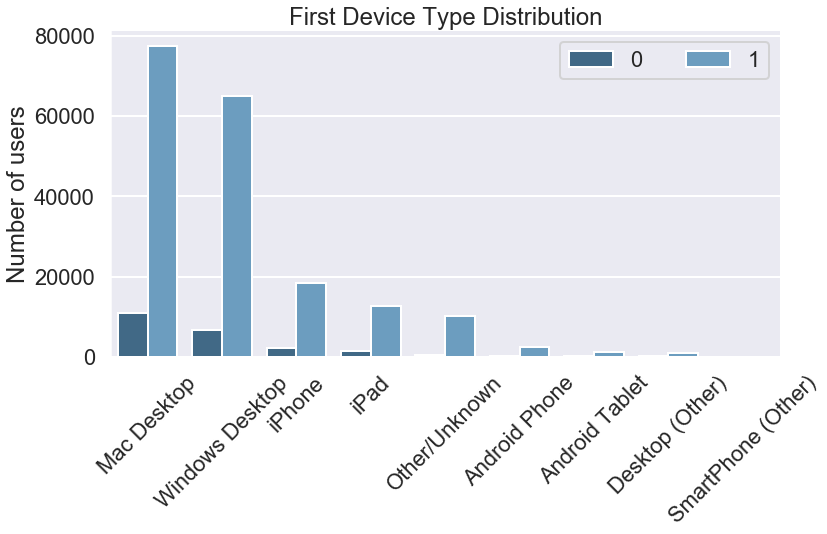

In [213]:
draw_plot('first_device_type','First Device Type Distribution',45,'Blues_d')

In [214]:
#we have a lot of first_browser but some of them only have few people use it
#Let's group those unpopular browsers as other
train.first_browser.unique()

array(['Chrome', 'IE', 'Firefox', 'Safari', 'Other', 'Mobile Safari',
       'Chrome Mobile', 'RockMelt', 'Chromium', 'Android Browser',
       'AOL Explorer', 'Palm Pre web browser', 'Opera', 'TenFourFox',
       'Mobile Firefox', 'IE Mobile', 'Apple Mail', 'Silk', 'Camino',
       'Arora', 'BlackBerry Browser', 'SeaMonkey', 'Iron',
       'Sogou Explorer', 'IceWeasel', 'Opera Mini', 'SiteKiosk',
       'Maxthon', 'Kindle Browser', 'CoolNovo', 'Conkeror', 'wOSBrowser',
       'Google Earth', 'Crazy Browser', 'Mozilla', 'OmniWeb',
       'PS Vita browser', 'NetNewsWire', 'CometBird', 'Comodo Dragon',
       'Flock', 'Pale Moon', 'Avant Browser', 'Opera Mobile',
       'Yandex.Browser', 'TheWorld Browser', 'SlimBrowser', 'Epic',
       'Stainless', 'Googlebot', 'Outlook 2007', 'IceDragon'],
      dtype=object)

In [392]:
browser_name=['Chrome','Safari','Firefox','IE','Mobile Safari','Chrome Mobile','Android Browser']

In [393]:
for i in train.first_browser.unique():
    if i not in browser_name:
        train.first_browser.replace(i,'Other',inplace=True)

In [299]:
train.first_browser.unique()

array(['Chrome', 'IE', 'Firefox', 'Safari', 'Other', 'Mobile Safari',
       'Chrome Mobile', 'Android Browser'], dtype=object)

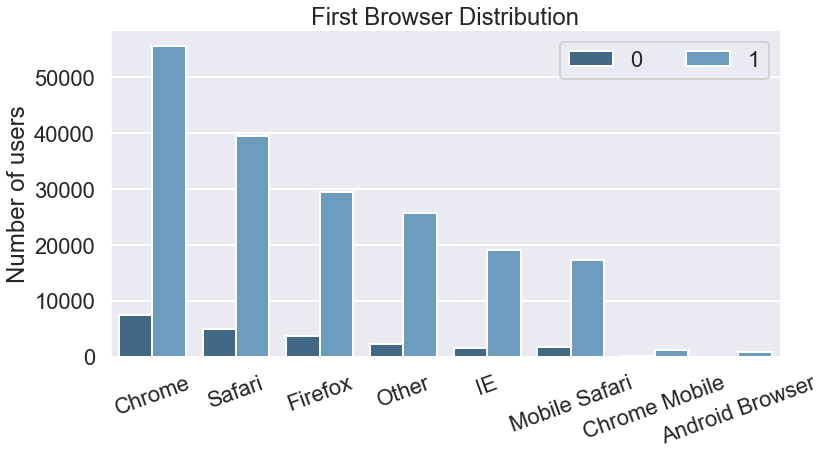

In [300]:
draw_plot('first_browser','First Browser Distribution',20,'Blues_d')

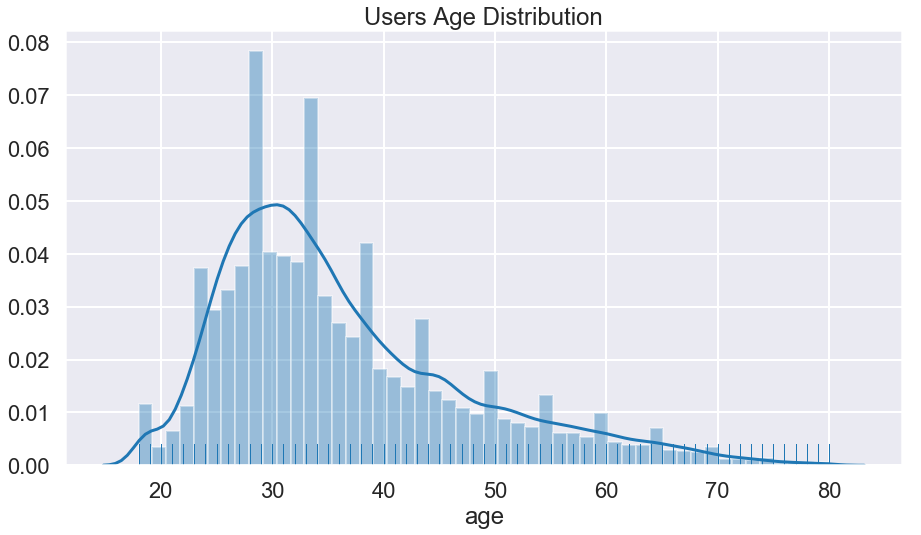

In [219]:
#age distribution
plt.figure(figsize=(15,8))
plt.title('Users Age Distribution')
sns.distplot(train.age.dropna(), rug=True);

In [324]:
age_grouped=train[train['book_within_a_month'] == 1].groupby('age').sum().reset_index()
age_grouped.sort_values('book_within_a_month', ascending=False).head(10)
#we can see that new customers between 26 to 35 are more likely to book a room within a month

,age,signup_flow,book_within_a_month
12,30.0,13826,5062
10,28.0,14318,4973
11,29.0,13723,4953
13,31.0,13269,4916
14,32.0,12415,4879
9,27.0,13981,4776
15,33.0,12056,4565
8,26.0,13058,4229
16,34.0,10238,4194
17,35.0,9784,4090


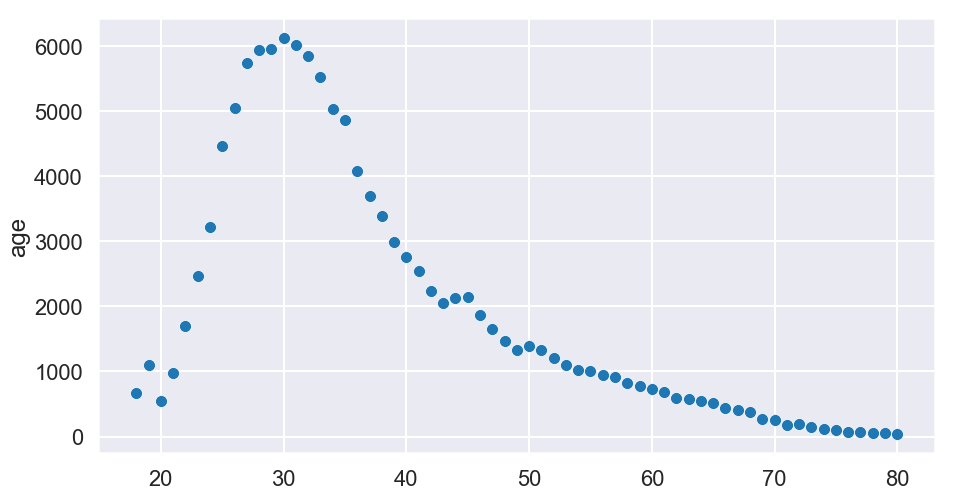

In [395]:
plt.figure(figsize=(15,8))
values = train.age.value_counts()
index = train.age.value_counts().index
sns.scatterplot(index, values);

In [396]:
target_yes = train.loc[train['book_within_a_month'] == 1]
target_no = train.loc[train['book_within_a_month'] == 0]

In [ ]:
plt.figure(figsize=(20,8))
sns.distplot(target_yes.age.dropna(),label='Booked within a month')
sns.distplot(target_no.age.dropna(),label='Did not book within a month')
sns.set_style("darkgrid")
plt.title('Age V.S Booking Distribution')
plt.ylabel('Probabilies of Booking')
plt.xlabel('Age')
plt.xticks(np.arange(15, 80, 5)) 
sns.despine()
plt.legend(loc='upper right', ncol=1,bbox_to_anchor=(1, 0.2),fontsize = 'small');

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(target_yes.signup_flow.dropna(),label='Booked within a month',rug=True, norm_hist=False)
sns.distplot(target_no.signup_flow.dropna(),label='Did not book within a month',rug=True, norm_hist=False)
sns.set_style("darkgrid")
plt.title('Signup Flow V.S Booking Distribution')
plt.ylabel('Signup Flow')
plt.xlabel('Signup Flow')
sns.despine()
plt.legend(loc='upper right', ncol=1,fontsize = 'small');

## Handling Missing Features -- Imputation

In [ ]:
train.columns

In [397]:
#create a dataframe 
df=train.copy()

In [398]:
df.drop(['day_of_week_first_booking','month_first_booking'],axis=1,inplace=True)

In [ ]:
df.isnull().sum()

In [399]:
#drop all the nan, so that we can train the data later
df_age=df.copy()
df_age_nan=df_age[df_age.age.isnull()]

In [400]:
df_age = df_age.reindex(columns=['age','signup_flow','book_within_a_month','gender','signup_method', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser'])
df_age_nan = df_age_nan.reindex(columns=['age','signup_flow','book_within_a_month','gender','signup_method', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser'])


In [401]:
#drop all the nan in df_age
df_age.dropna(inplace=True)

In [402]:
#dummy variables with no null values
df_age_d=pd.get_dummies(df_age)
#dummy variables on the age with all null
df_age_nan_d=pd.get_dummies(df_age_nan)

In [403]:
df_age_nan_d.shape

(87990, 53)

In [404]:
df_age_d.shape

(122532, 53)

In [405]:
#convert dataframe without gender and first_browser to array 
df_age_matrix = df_age_d.values
df_age_nan_matrix=df_age_nan_d.values

In [406]:

# Train KNN learner
clf = KNeighborsClassifier(3, weights='distance', n_jobs=-1)
trained_model = clf.fit(df_age_matrix[:,1:], df_age_matrix[:,0].astype(int))

In [407]:
# Predict missing values' class
age_imputed_values = trained_model.predict(df_age_nan_matrix[:,1:])

In [408]:
age_imputed_values.reshape(-1,1).shape, df_age_nan_matrix[:,1:].shape

((87990, 1), (87990, 52))

In [409]:
X_with_imputed=np.hstack((age_imputed_values.reshape(-1,1), df_age_nan_matrix[:,1:]))

In [410]:
X_with_imputed.shape

(87990, 53)

In [411]:
# Join two feature matrices
df_final=np.vstack((X_with_imputed,df_age_matrix ))

In [412]:
df_final = pd.DataFrame(data=df_final, columns=df_age_d.columns)
df_final.head()

,age,signup_flow,book_within_a_month,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,language_Other,...,first_device_type_iPad,first_device_type_iPhone,first_browser_Android Browser,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Firefox,first_browser_IE,first_browser_Mobile Safari,first_browser_Other,first_browser_Safari
0,28.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,26.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,31.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,18.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [413]:
df_final.to_pickle("./airbnb_data.pkl")